In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from scipy.optimize import linprog


class RationalClassifier:
    def __init__(self, numerator_degree, denominator_degree, n_components, delta=1e-5, precision=1e-6):
        self.numerator_degree = numerator_degree
        self.denominator_degree = denominator_degree
        self.n_components = n_components
        self.delta = delta
        self.precision = precision
        self.alpha = None
        self.beta = None
        self.z = None

    def fit(self, X, y):
        """
        Train the rational classifier by solving for optimal alpha, beta, and z.
        """
        # Generate rational function matrices
        G_matrix, H_matrix = generate_rational_function_matrix(
            self.numerator_degree, self.denominator_degree, self.n_components, X
        )
        
        # Use bisection method to find optimal z
        self.z = bisection_method(
            uL=0, uH=100, G_matrix=G_matrix, H_matrix=H_matrix, y=y, precision=self.precision
        )
        
        # Solve for alpha and beta at the optimal z
        result = solve_lp(self.z, G_matrix, H_matrix, y, delta=self.delta)
        if not result.success:
            raise ValueError("Linear programming failed to converge.")
         
        
        # Extract alpha and beta coefficients
        self.alpha = result.x[1 : 1 + G_matrix.shape[1]]
        self.beta = result.x[1 + G_matrix.shape[1] :]

    def predict(self, X):
        """
        Predict class labels for input data X.
        """
        # Generate rational function matrices for prediction
        G_matrix, H_matrix = generate_rational_function_matrix(
            self.numerator_degree, self.denominator_degree, self.n_components, X
        )
        
        # Compute rational function values
        numerator = np.dot(G_matrix, self.alpha)
        denominator = 1 + np.dot(H_matrix, self.beta)
        rational_values = numerator / denominator
        
        # Apply threshold to classify
        predictions = (rational_values > 0.3).astype(int)
        return predictions


# Generating multi-indices
def r_multi_indices(n, d):
    if n == 1:
        yield (d,)
    else:
        for k in range(d + 1):
            for c in r_multi_indices(n - 1, k):
                yield (d - k, *c)


def generate_multi_indices(n, d):
    from itertools import chain
    return list(chain(*[list(r_multi_indices(n, _)) for _ in range(d + 1)]))


# Generating rational function matrices
def generate_rational_function_matrix(numerator_degree, denominator_degree, n_components, dataset):
    G_indices = generate_multi_indices(n_components, numerator_degree)
    H_indices = generate_multi_indices(n_components, denominator_degree)

    G_matrix = np.zeros((len(dataset), len(G_indices)))
    H_matrix = np.zeros((len(dataset), len(H_indices)))

    for i, data_point in enumerate(dataset):
        G_matrix[i] = [np.prod([data_point[k] ** idx[k] for k in range(len(data_point))]) for idx in G_indices]
        H_matrix[i] = [np.prod([data_point[k] ** idx[k] for k in range(len(data_point))]) for idx in H_indices]

    return G_matrix, H_matrix


# Linear programming setup
def solve_lp(z, G_matrix, H_matrix, y, delta=1e-5):
    length_dataset = len(y)
    num_alpha = G_matrix.shape[1]
    num_beta = H_matrix.shape[1]

    c = [1] + [0] * (num_alpha + num_beta)
    
    A_ub, b_ub = [], []

    for i in range(length_dataset):
        G_row = G_matrix[i]
        H_row = H_matrix[i]
        y_i = y[i]

        # First constraint
        A_ub.append([-1] + [-g for g in G_row] + [(y_i - z) * h for h in H_row])
        b_ub.append(0)

        # Second constraint
        A_ub.append([-1] + [g for g in G_row] + [-(y_i - z) * h for h in H_row])
        b_ub.append(0)

        # Positivity constraint
        A_ub.append([0] + [0] * num_alpha + [-h for h in H_row])
        b_ub.append(-delta)

    bounds = [(0, None)] + [(None, None)] * (num_alpha + num_beta)
    result = linprog(c=c, A_ub=np.array(A_ub), b_ub=np.array(b_ub), bounds=bounds, method="highs")
   # print(f"Optimization result: {result}")
    return result

# Bisection method to find optimal z
#def bisection_method(uL, uH, G_matrix, H_matrix, y, precision=1e-6):
   # while (uH - uL) > precision:
     #   z = (uH + uL) / 2
      #  result = solve_lp(z, G_matrix, H_matrix, y)
      #  if result.success:
        #    uH = z
       # else:
         #   uL = z
  #  return uH

def bisection_method(uL, uH, G_matrix, H_matrix, y, precision=1e-6):
    logs = []
    while (uH - uL) > precision:
        z = (uH + uL) / 2
        result = solve_lp(z, G_matrix, H_matrix, y)
        logs.append((z, result.success))
        if result.success:
            uH = z
        else:
            uL = z
    # Visualize logs
    print("Bisection Logs:", logs)
    return uH


X shape: (70000, 784), y_binary shape: (70000,)
X_train_reduced shape: (56000, 5)
X_test_reduced shape: (14000, 5)
PCA: Variance explained by 5 components: 0.33
Binarized X_train shape: (56000, 5)
Binarized X_test shape: (14000, 5)
Bisection Logs: [(50.0, True), (25.0, True), (12.5, True), (6.25, True), (3.125, True), (1.5625, True), (0.78125, True), (0.390625, True), (0.1953125, True), (0.09765625, True), (0.048828125, True), (0.0244140625, True), (0.01220703125, True), (0.006103515625, True), (0.0030517578125, True), (0.00152587890625, True), (0.000762939453125, True), (0.0003814697265625, True), (0.00019073486328125, True), (9.5367431640625e-05, True), (4.76837158203125e-05, True), (2.384185791015625e-05, True), (1.1920928955078125e-05, True), (5.9604644775390625e-06, True), (2.9802322387695312e-06, True), (1.4901161193847656e-06, True), (7.450580596923828e-07, True)]
Rational Classifier training completed.
Accuracy on test data: 0.90
Class distribution in training data: Counter({0:

<Axes: >

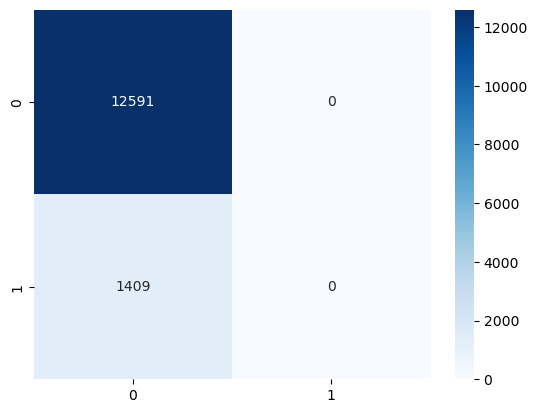

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype(int)


# Load dataset
#data= r"C:\Users\Besitzer\data"
#df = pd.read_csv("data.csv")
# Separate features (X) and labels (y)
#X = df.iloc[:, :-1].values  # Features: All columns except the last
#y = df.iloc[:, -1].values   # Target: Last column

# Transform labels: Create binary classification for digit 8
y_binary = (y == 8).astype(int)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2)
print(f"X shape: {X.shape}, y_binary shape: {y_binary.shape}")

#X_small, y_small = X_train[:10], y_train[:10]


# PCA Transformation
n_components = 5 # Number of principal components
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
print(f"X_train_reduced shape: {X_train_reduced.shape}")
print(f"X_test_reduced shape: {X_test_reduced.shape}")

# Variance explained by PCA
variance_explained = np.sum(pca.explained_variance_ratio_)
print(f"PCA: Variance explained by {n_components} components: {variance_explained:.2f}")

# Binarize the PCA output
threshold_value = 0
X_train_bin = (X_train_reduced > threshold_value).astype(int)
X_test_bin = (X_test_reduced > threshold_value).astype(int)
print(f"Binarized X_train shape: {X_train_bin.shape}")
print(f"Binarized X_test shape: {X_test_bin.shape}")

# Train the Rational Classifier
numerator_degree = 2
denominator_degree = 2

# Initialize the classifier
model = RationalClassifier(
    numerator_degree=numerator_degree,
    denominator_degree=denominator_degree,
    n_components=n_components
)

# Fit the model
model.fit(X_train_reduced, y_train)
print("Rational Classifier training completed.")


#model.fit(X_small, y_small)
#y_small_pred = model.predict(X_small)
#print("Small dataset predictions:", y_small_pred)


# Predict on the test data
y_pred = model.predict(X_test_reduced)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.2f}")

print("Class distribution in training data:", Counter(y_train))
print("Class distribution in test data:", Counter(y_test))
print("Alpha coefficients:", model.alpha)
print("Beta coefficients:", model.beta)
print("Optimal z value:", model.z)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(start_index, end_index, model, X_test, y_test, original_images, title="Prediction Visualization"):
    """
    Visualize predictions made by the RationalClassifier and compare them to true labels.

    Parameters:
    - start_index: The starting index of the test dataset to visualize.
    - end_index: The ending index of the test dataset to visualize.
    - model: Trained RationalClassifier instance.
    - X_test: Transformed test dataset (binarized PCA output).
    - y_test: True binary labels of the test dataset.
    - original_images: Original test images (flattened) for visualization.
    - title: Title of the visualization plot.
    """
    # Number of rows and columns for the grid
    rows = int(np.ceil((end_index - start_index) / 5))  # 5 images per row
    cols = 5

    # Create a figure
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    fig.suptitle(title, fontsize=16, weight='bold')

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Generate predictions for the specified range
    predictions = model.predict(X_test[start_index:end_index])

    # Iterate through the specified range
    for idx, ax in zip(range(start_index, end_index), axes):
        # Predicted and true labels for the current index
        predicted_digit = predictions[idx - start_index]
        true_digit = y_test[idx]

        # Reshape the flattened image back to its original shape (28x28)
        image = original_images[idx].reshape(28, 28)

        # Determine correctness
        status = "correct✔️" if predicted_digit == true_digit else "wrong✖️"

        # Plot the image
        ax.imshow(image, cmap='gray')  # Use 'gray' colormap for MNIST
        ax.set_title(f"Pred: {predicted_digit}, True: {true_digit}\n{status}")
        ax.axis("off")  # Hide axes for cleaner visuals

    # Turn off unused subplots
    for ax in axes[len(range(start_index, end_index)):]:
        ax.axis("off")

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
    plt.show()


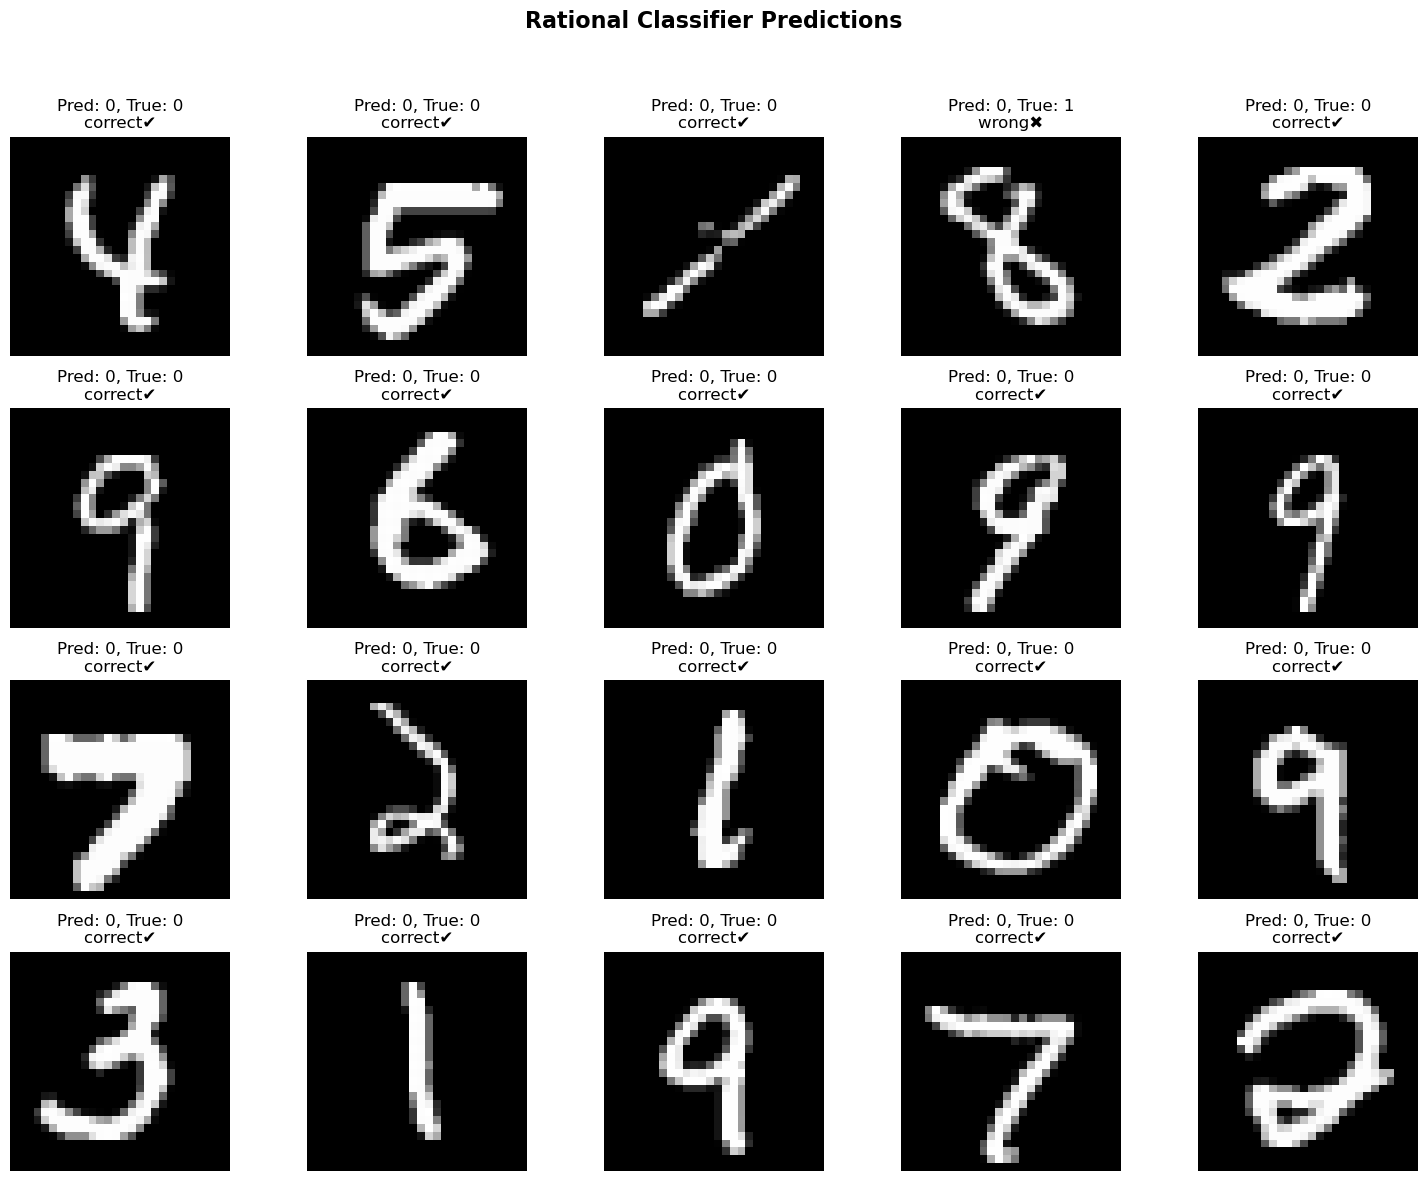

In [6]:
# Assuming you've already trained the RationalClassifier and have the datasets ready

# Test subset for visualization (original images in flattened format)
original_images = X_test  # Use original test images (not PCA-transformed or binarized)
start_index = 0
end_index = 20  # Adjust this range as needed

# Visualize predictions
visualize_predictions(
    start_index=start_index,
    end_index=end_index,
    model=model,  # Your trained RationalClassifier instance
    X_test=X_test_bin,  # Binarized PCA-transformed test dataset
    y_test=y_test,  # True binary labels
    original_images=original_images,  # Original test images
    title="Rational Classifier Predictions"
)